In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

SEED = 15000
#Reproducability
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.17.1
1.26.4
2.2.3


# Loading Data #
Load legend and images into seperate dataframes

In [2]:
def load_data(legend_dir, image_dir, image_size=(350, 350)):
    images = []
    labels = []

    df = pd.read_csv(legend_dir)
    # Convert all labels in the 'emotion' column to lowercase
    df['emotion'] = df['emotion'].str.lower()
    
    for _ , row in df.iterrows():
        img_path = os.path.join(image_dir, row['image'])

        # Grayscale, 1 channel
        img = image.load_img(img_path, target_size=image_size, color_mode='grayscale')
        
        img_array = image.img_to_array(img)
        images.append(img_array)
        
        # Get label 
        labels.append(row['emotion'])
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [ ]:
base = "/kaggle/input/emotions-data-cs178"

images, labels = load_data(f"{base}/data/legend.csv", f"{base}/images")

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Data Analysis #

Exploring label feature

Label
neutral      6868
happiness    5696
surprise      368
sadness       268
anger         252
disgust       208
fear           21
contempt        9
Name: count, dtype: int64


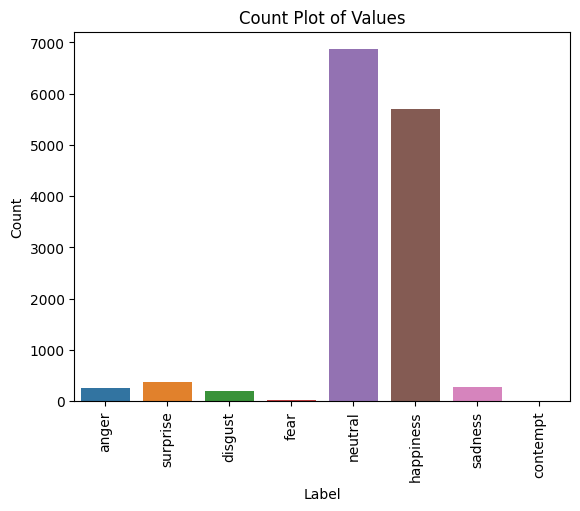

In [4]:
df_labels = pd.DataFrame(labels, columns=['Label'])

print(df_labels['Label'].value_counts())

sns.countplot(x='Label', data=df_labels)
plt.title('Count Plot of Values')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

We have very few examples of contempt and fear, meaning training our model to predict these target values will be very difficult. It is feasible to ignore these target values completely or to group contempt with anger as these two emotions are very similar. This may also influence what kind of loss function we want to use to maybe weight mistakes on rarer classes heavier than on more common classes.

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(20, 50))

i = 0
for label in df_labels['Label'].unique():
    example_label = df_labels[df_labels['Label'] == label].iloc[i]
    index = example_label.name
    example_image = images[index]
    ax[i].imshow(example_image, cmap='gray')
    ax[i].set_title(example_label['Label'])
    ax[i].axis('off')
    
    i+=1
    
plt.show()

# Preprocessing #

We encode our label values as integers so that our models can learn to predict these integer values. Then we one-hot encode to fit what a neural network would learn to predict: probabilites for each class.

In [6]:
#Label encode and then one hot encode so neural network can learn to predict probabilities
label_map = {'anger': 0,
             'surprise': 1,
             'disgust': 2,
             'fear': 3,
             'neutral': 4,
             'happiness': 5,
             'sadness': 6,
             'contempt': 7}

map_func = np.vectorize(lambda x: label_map.get(x, x))
labels = map_func(labels)
labels = to_categorical(labels, num_classes=8)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

We normalize our data by dividing by 255 since that's the max pixel value. Keeping values between 0 and 1 stabilizes the gradient when training CNNs.

In [7]:
#NORMALIZE DATA
images = images / 255

Now, we split our data into our testing, training, and validation sets. We opted for two 80/20 splits for a balance between preserving training data and having enough testing/validation data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)
#Save ram
del images 
del labels

print(f"Training Size: {X_train.shape[0]}")
print(f"Testing Size: {X_test.shape[0]}")
print(f"Validation Size: {X_val.shape[0]}")

Training Size: 8761
Testing Size: 2738
Validation Size: 2191


# Modeling #

MAKE SURE TO TURN ON GPU ACCELERATOR ON KAGGLE TO SPEED UP TRAINING

In [9]:
model = keras.Sequential([
    layers.InputLayer(shape=(350, 350, 1)),
   
    # #Image augmentation (Moved to data prefetch)
    # layers.RandomRotation(0.075),
    # layers.RandomZoom(0.15),
    # layers.RandomHeight(0.1),
    # layers.RandomWidth(0.1),
    # layers.Resizing(350, 350),
    
    #Block 1
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block 2
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    #Block 3
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block 4
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    
    #Dense Head
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(8, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 350, 350, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 350, 350, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 175, 175, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 175, 175, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 175, 175, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 175, 175, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 87, 87, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 43, 43, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 43, 43, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 431,432 (1.65 MB)

 Trainable params: 430,472 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

Compile model with Adam

In [10]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

Convert data to tensorflow datasets. This allows us to prefetch. Grab and apply image augmentation to the next bactch while the previous is used for training.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE #Parallel processing

def augment(image, label):
    image = tf.image.stateless_random_flip_left_right(image)
    image = tf.image.stateless_random_brightness(image, max_delta=0.1)
    image = tf.image.stateless_random_crop(image, size=[320, 320, 1])
    image = tf.image.stateless_random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.resize(image, [350, 350])
    return image, label

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE) 
ds_train = ds_train.shuffle(1000).batch(64).prefetch(AUTOTUNE) #Shuffle prevents overfitting to data order

ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_val = ds_val.batch(64).prefetch(AUTOTUNE)

#Free memory
del X_train
del y_train
del X_val
del y_val


NameError: name 'X_train' is not defined

Train model using reduce_lr and early_stopping callbacks

In [15]:
epochs = 50
batch_size = 64
stop_patience = 8

#Reduce lr when no improvement
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,  
    patience=3,  
    min_lr=1e-6  
)

#Early stopping and restore best weights with lowest val_loss
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=stop_patience, 
    restore_best_weights=True 
)

history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1 )

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 52s 350ms/step - accuracy: 0.4884 - loss: 1.0238 - val_accuracy: 0.4249 - val_loss: 1.1181 - learning_rate: 0.0010
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 0.5146 - loss: 0.9930 - val_accuracy: 0.4245 - val_loss: 1.1823 - learning_rate: 0.0010
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 52s 351ms/step - accuracy: 0.5100 - loss: 0.9867 - val_accuracy: 0.4528 - val_loss: 1.1143 - learning_rate: 0.0010
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.5293 - loss: 0.9871 - val_accuracy: 0.4167 - val_loss: 1.8585 - learning_rate: 0.0010
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 51s 346ms/step - accuracy: 0.5326 - loss: 0.9746 - val_accuracy: 0.4153 - val_loss: 1.8610 - learning_rate: 0.0010
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 52s 349ms/step - accuracy: 0.5779 - loss: 0.9418 - val_accuracy: 0.4856 - val_loss: 1.1802 - learning_rate: 0.0010
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 52s 347ms/step - accuracy: 0.6

Best validation loss: 0.6970613598823547
Best validation accuracy: 0.7635782957077026


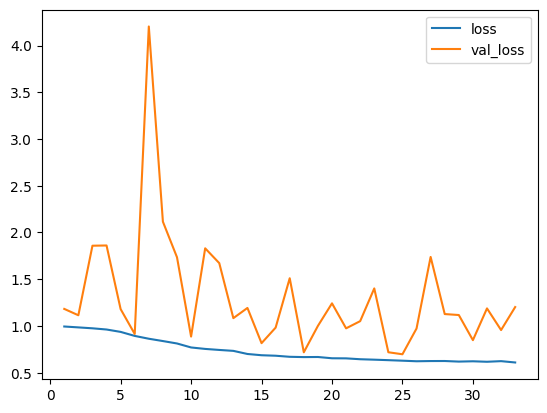

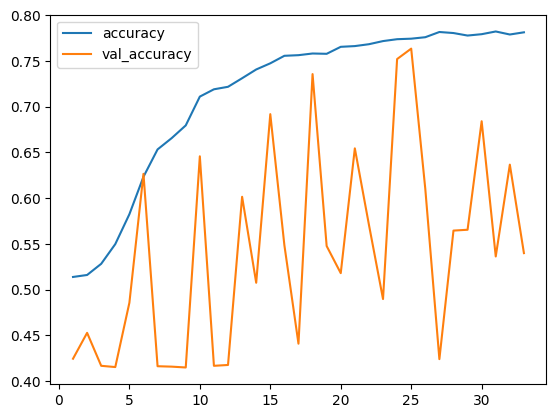

In [16]:
df_history = pd.DataFrame(history.history)
print(f"Best validation loss: {df_history['val_loss'].min()}")
print(f"Best validation accuracy: {df_history['val_accuracy'].max()}")
df_history.loc[1:, ['loss', 'val_loss']].plot()
df_history.loc[1:, ['accuracy', 'val_accuracy']].plot();

Save model

In [ ]:
model.save("/kaggle/working/emotion_model.keras")
